In [3]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit.primitives import Estimator
from qiskit import Aer

In [ ]:
# Step 2: Load Dataset
df = pd.read_csv(r'C:/Users/Dhara/Downloads/Genome_Data.csv')

In [5]:
# Step 3: Feature Engineering
features = pd.DataFrame()
features['Gene_Count'] = df['Gene Count']

# Encode Domain
le_domain = LabelEncoder()
features['Domain_Encoded'] = le_domain.fit_transform(df['Domain'])

# Encode Body Site
le_site = LabelEncoder()
features['Body_Site_Encoded'] = le_site.fit_transform(df['HMP Isolation Body Site'])

# Feature interaction
features['GeneCount_x_Domain'] = features['Gene_Count'] * features['Domain_Encoded']
features['GeneCount_x_BodySite'] = features['Gene_Count'] * features['Body_Site_Encoded']

In [6]:
# Step 4: Data Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

C:\Users\Dhara\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Dhara\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Program Files\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python311\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python311\Lib\subprocess.py", line 1509, in _execute_ch

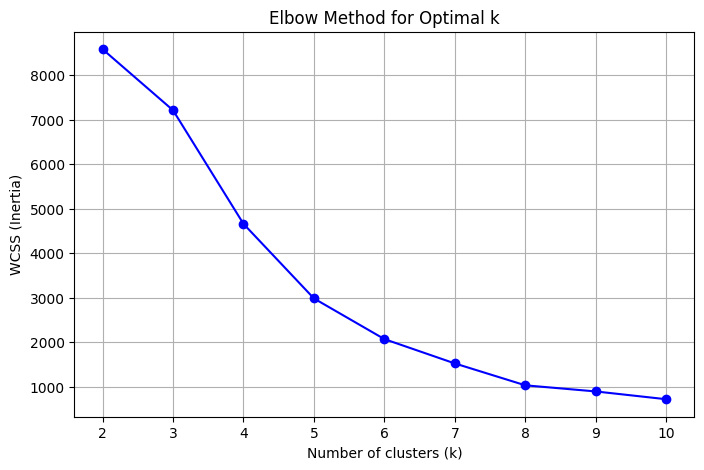

In [7]:
# Step 5: Elbow Method to find optimal k
wcss = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

optimal_k = 3

In [8]:
# Step 6: Classical KMeans Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
classical_labels = kmeans.fit_predict(scaled_features)

In [9]:
# Step 7: Quantum Hybrid Clustering Setup
feature_map = ZZFeatureMap(feature_dimension=scaled_features.shape[1], reps=2, entanglement='linear')
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

# Compute Quantum Kernel Matrix
kernel_matrix = quantum_kernel.evaluate(x_vec=scaled_features)

# Apply KMeans on Quantum Kernel matrix
eigenvalues, eigenvectors = np.linalg.eigh(kernel_matrix)
pca_quantum = eigenvectors[:, :2]
kmeans_quantum = KMeans(n_clusters=optimal_k, random_state=42)
quantum_labels = kmeans_quantum.fit_predict(pca_quantum)

C:\Users\Dhara\AppData\Local\Temp\ipykernel_19112\555537321.py:3: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))


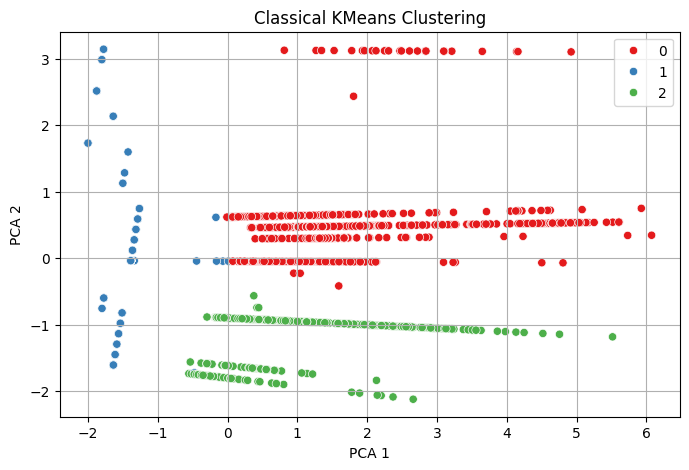

In [10]:
# Step 8: Visualization - Classical
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(8,5))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=classical_labels, palette='Set1')
plt.title('Classical KMeans Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid()
plt.show()

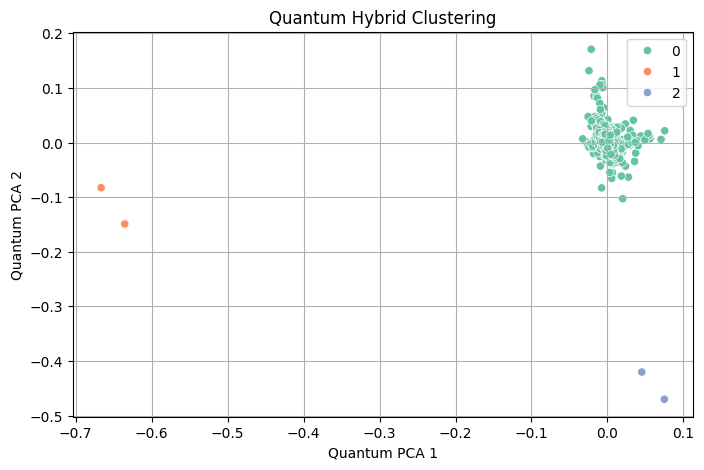

In [11]:
# Step 9: Visualization - Quantum
plt.figure(figsize=(8,5))
sns.scatterplot(x=pca_quantum[:,0], y=pca_quantum[:,1], hue=quantum_labels, palette='Set2')
plt.title('Quantum Hybrid Clustering')
plt.xlabel('Quantum PCA 1')
plt.ylabel('Quantum PCA 2')
plt.grid()
plt.show()

In [12]:
# Step 10: Metric Calculation
silhouette_classical = silhouette_score(scaled_features, classical_labels)
davies_classical = davies_bouldin_score(scaled_features, classical_labels)

silhouette_quantum = silhouette_score(pca_quantum, quantum_labels)
davies_quantum = davies_bouldin_score(pca_quantum, quantum_labels)

In [13]:
# Step 11: Results Comparison
results = pd.DataFrame({
    'Model': ['Classical KMeans', 'Quantum Hybrid KMeans'],
    'Silhouette Score (Higher Better)': [silhouette_classical, silhouette_quantum],
    'Davies-Bouldin Index (Lower Better)': [davies_classical, davies_quantum]
})

print(results)

                   Model  Silhouette Score (Higher Better)  \
0       Classical KMeans                          0.418467   
1  Quantum Hybrid KMeans                          0.962940   

   Davies-Bouldin Index (Lower Better)  
0                             1.006627  
1                             0.087200  


In [14]:
# Step 12: Percentage Improvement
silhouette_improve = ((silhouette_quantum - silhouette_classical) / abs(silhouette_classical)) * 100
davies_improve = ((davies_classical - davies_quantum) / abs(davies_classical)) * 100

print(f"\nSilhouette Score Improvement (%): {silhouette_improve:.2f}%")
print(f"Davies-Bouldin Index Improvement (%): {davies_improve:.2f}%")


Silhouette Score Improvement (%): 130.11%
Davies-Bouldin Index Improvement (%): 91.34%


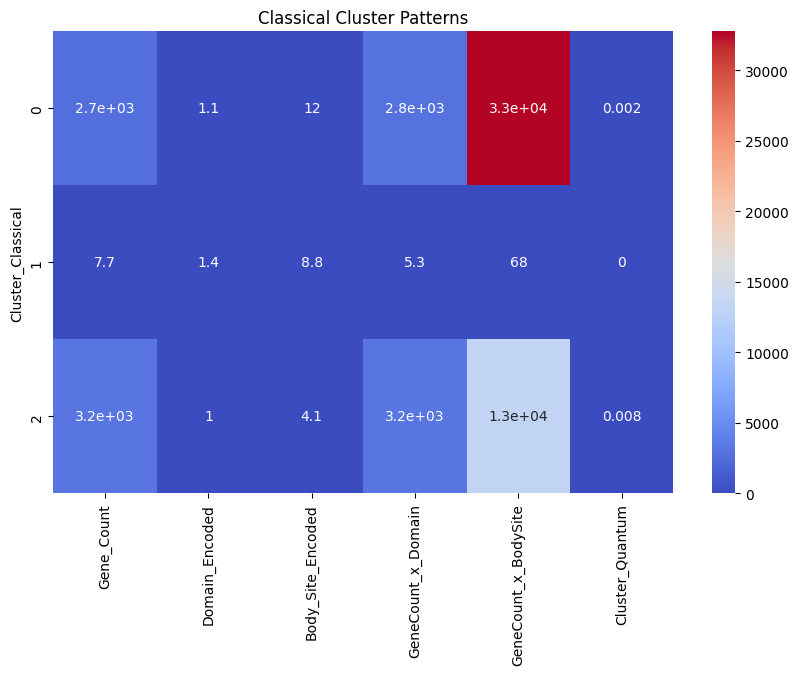

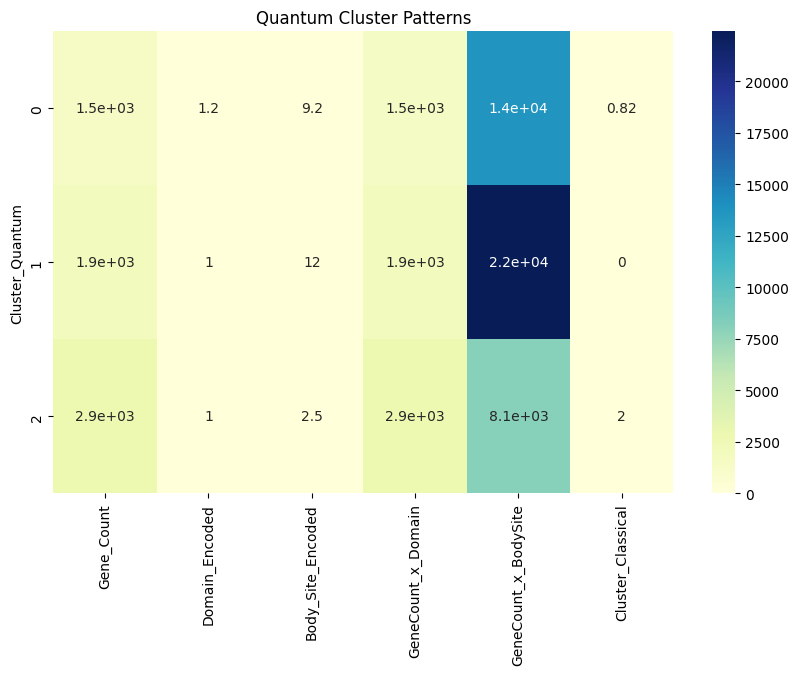

In [15]:
# Step 13: Cluster Pattern Heatmaps
features['Cluster_Classical'] = classical_labels
features['Cluster_Quantum'] = quantum_labels

plt.figure(figsize=(10,6))
sns.heatmap(features.groupby('Cluster_Classical').mean(), annot=True, cmap='coolwarm')
plt.title('Classical Cluster Patterns')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(features.groupby('Cluster_Quantum').mean(), annot=True, cmap='YlGnBu')
plt.title('Quantum Cluster Patterns')
plt.show()


Biological Insights:

Cluster 0:
Dominant Body Sites: gastrointestinal_tract
Average Gene Count: 1473.35
Domain Distribution:
Domain
BACTERIAL    99.409158
EUKARYAL      0.295421
VIRUS         0.221566
ARCHAEAL      0.073855
Name: proportion, dtype: float64


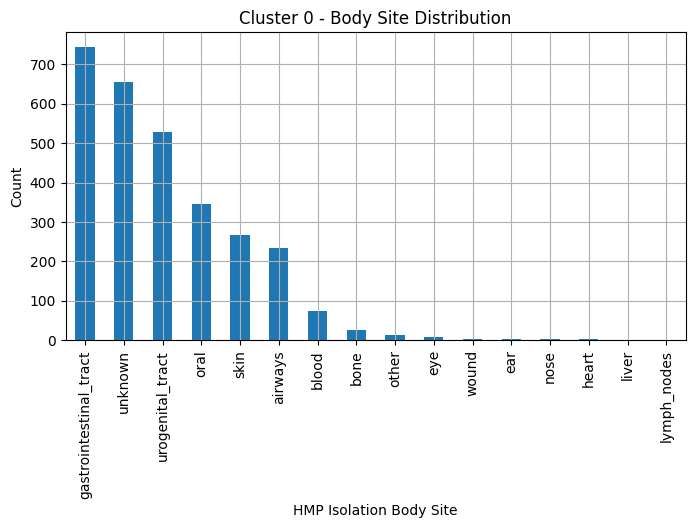

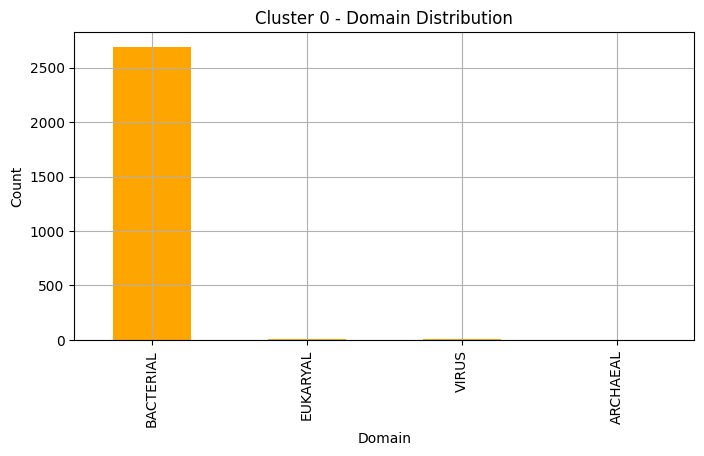


Cluster 1:
Dominant Body Sites: oral, urogenital_tract
Average Gene Count: 1933.00
Domain Distribution:
Domain
BACTERIAL    100.0
Name: proportion, dtype: float64


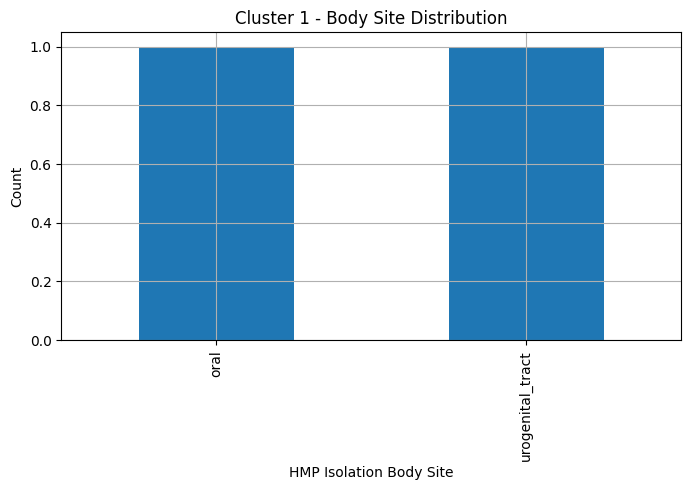

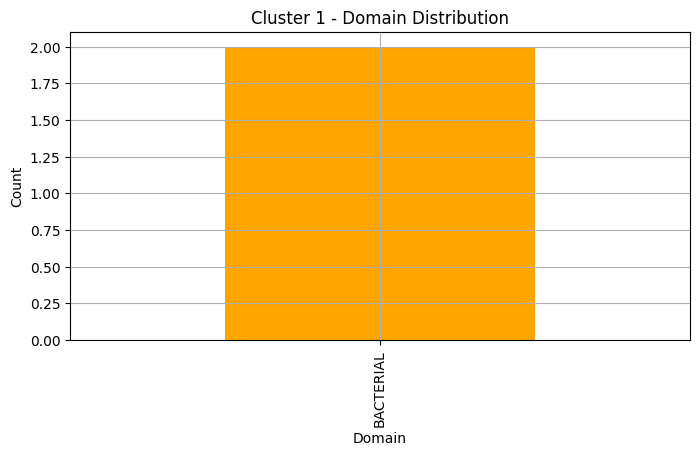


Cluster 2:
Dominant Body Sites: airways, gastrointestinal_tract
Average Gene Count: 2863.50
Domain Distribution:
Domain
BACTERIAL    100.0
Name: proportion, dtype: float64


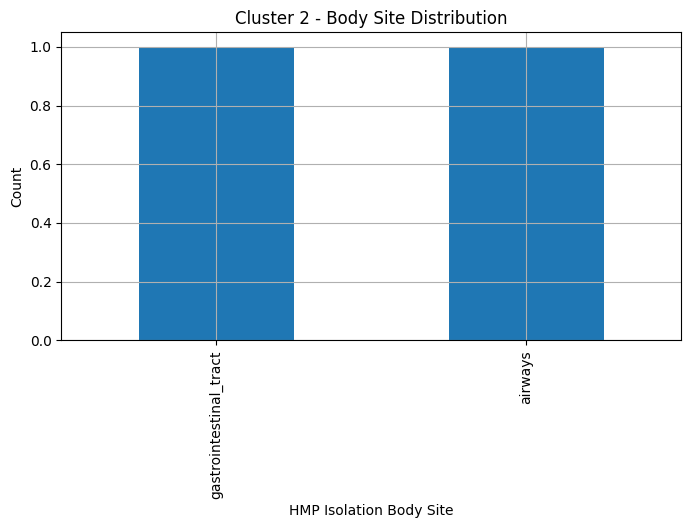

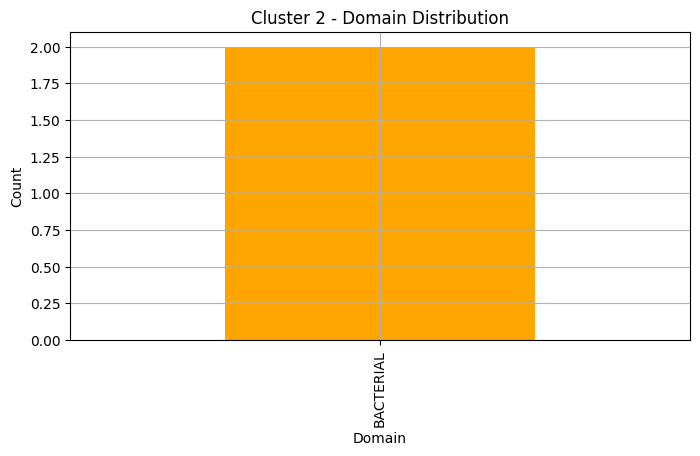

In [16]:
# Step 14: Biological Insights
print("\nBiological Insights:")
for cluster in sorted(features['Cluster_Quantum'].unique()):
    subset = df.loc[features['Cluster_Quantum'] == cluster]
    dominant_sites = subset['HMP Isolation Body Site'].mode()
    avg_gene_count = subset['Gene Count'].mean()
    domain_distribution = subset['Domain'].value_counts(normalize=True) * 100

    print(f"\nCluster {cluster}:")
    print(f"Dominant Body Sites: {', '.join(dominant_sites)}")
    print(f"Average Gene Count: {avg_gene_count:.2f}")
    print("Domain Distribution:")
    print(domain_distribution)

    subset['HMP Isolation Body Site'].value_counts().plot(kind='bar', figsize=(8,4), title=f"Cluster {cluster} - Body Site Distribution")
    plt.ylabel('Count')
    plt.grid()
    plt.show()

    subset['Domain'].value_counts().plot(kind='bar', figsize=(8,4), title=f"Cluster {cluster} - Domain Distribution", color='orange')
    plt.ylabel('Count')
    plt.grid()
    plt.show()

In [17]:
# Step 15: Conclusion
print("\nConclusion:")
if silhouette_classical > silhouette_quantum:
    print("Classical KMeans achieved better cluster compactness.")
else:
    print("Quantum Hybrid achieved better cluster compactness.")

if davies_classical < davies_quantum:
    print("Classical KMeans achieved better separation (lower Davies-Bouldin index).")
else:
    print("Quantum Hybrid achieved better separation (lower Davies-Bouldin index).")


Conclusion:
Quantum Hybrid achieved better cluster compactness.
Quantum Hybrid achieved better separation (lower Davies-Bouldin index).


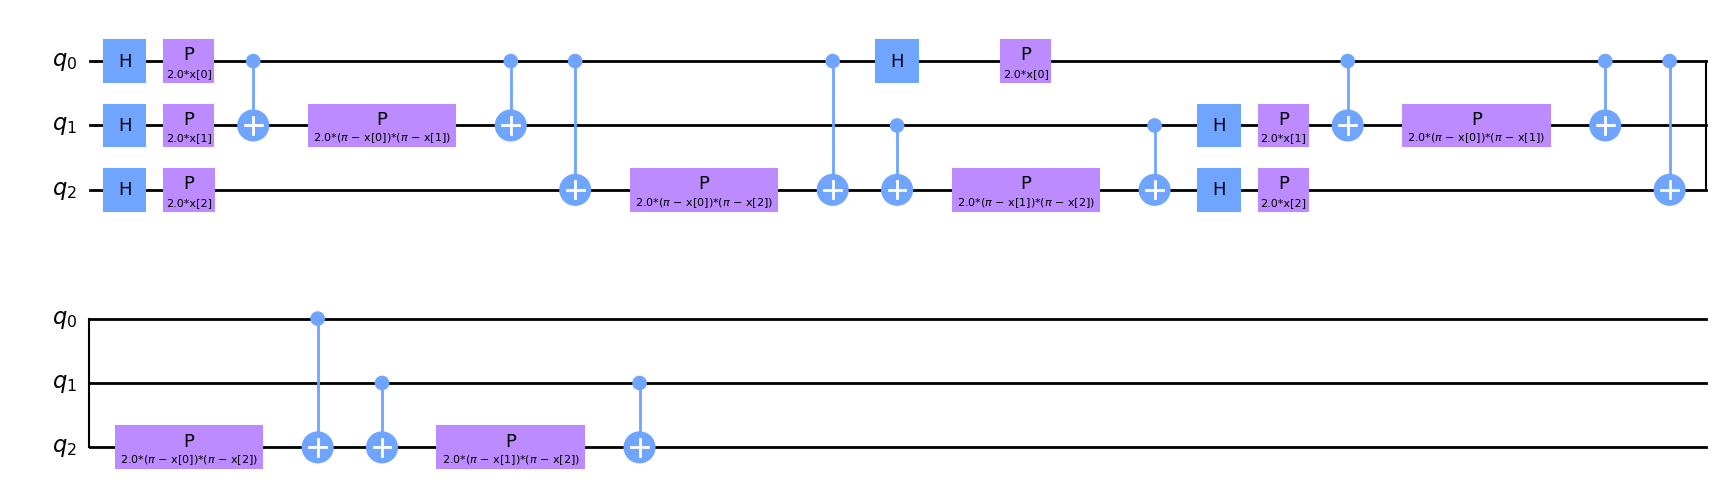

In [ ]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt


num_features = 3


feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement='full')


feature_map.decompose().draw('mpl')
